## Making Visualizations

Let's make visualizations to explain our results!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Permutation Importances

In [10]:
# First, let's construct the model again.

df = pd.read_csv('training-data.csv')
train = df[df['Year'] < 2018]
test = df[df['Year'] == 2018]

drop_features = ['Target', 'Player', 'Tm']
X_train = train.drop(drop_features, axis=1)
y_train = train['Target']
X_test = test.drop(drop_features, axis=1)
y_test = test['Target']

In [8]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [9]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=504)

model.fit(X_train_encoded, y_train)

Ridge(alpha=504, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
# Check to see which metrics there are for permutation importances.

import sklearn.metrics

sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [11]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=30
)

permuter.fit(X_test_encoded, y_test)

PermutationImportance(cv='prefit',
                      estimator=Ridge(alpha=504, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=False, random_state=None,
                                      solver='auto', tol=0.001),
                      n_iter=5, random_state=30, refit=True,
                      scoring='neg_mean_squared_error')

In [12]:
feature_names = X_test_encoded.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

# Looks like there are four truly import features: adjusted points is first (!), followed by adjusted assists,
# then career assists, and finally regular assists is fourth. A bunch more have *some* importance, though.

Weight,Feature
0.9422 ± 0.1681,PTS_adj
0.8612 ± 0.1186,AST_adj
0.7693 ± 0.1793,CAS
0.7445 ± 0.1159,AST
0.3661 ± 0.0732,TM_PTS_adj
0.3322 ± 0.0942,3P_adj
0.2704 ± 0.0385,MP
0.2575 ± 0.0329,TM_FG_adj
0.2005 ± 0.0400,FGA_adj
0.1821 ± 0.0255,2P_adj


In [13]:
# I'll just show the features with importance at least 0.01.

eli5.show_weights(
    permuter,
    top=31,
    feature_names=feature_names
)

Weight,Feature
0.9422 ± 0.1681,PTS_adj
0.8612 ± 0.1186,AST_adj
0.7693 ± 0.1793,CAS
0.7445 ± 0.1159,AST
0.3661 ± 0.0732,TM_PTS_adj
0.3322 ± 0.0942,3P_adj
0.2704 ± 0.0385,MP
0.2575 ± 0.0329,TM_FG_adj
0.2005 ± 0.0400,FGA_adj
0.1821 ± 0.0255,2P_adj


### Scatter plots

I'll make some scatter plots to show how the most important features relate to the Target column.

In [21]:
imp_features = {'PTS_adj': 'Adjusted Points', 'AST_adj': "Adjusted Assists",
                'CAS': 'Average Career Assists', 'AST': 'Assists per Game'}

names = list(imp_features.keys())

meanings = list(imp_features.values())

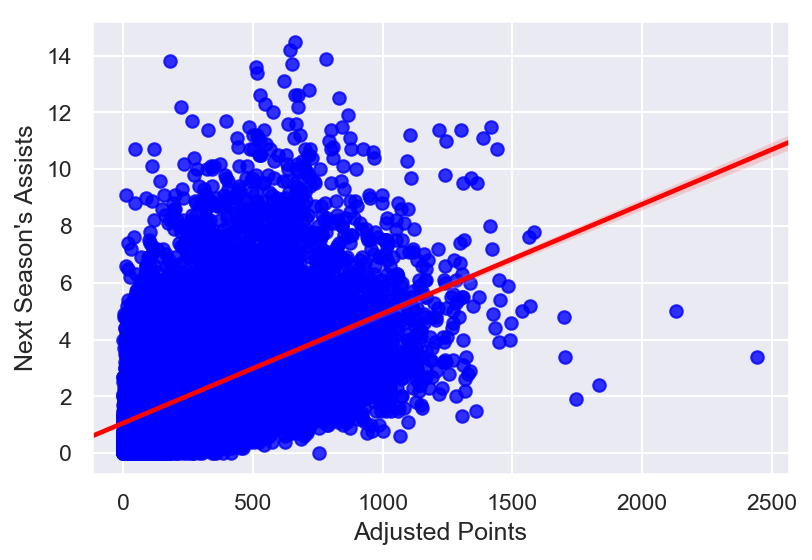

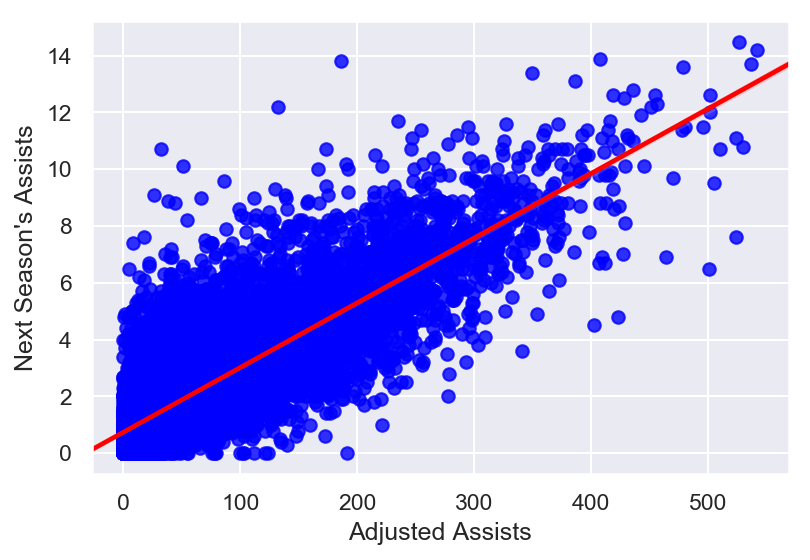

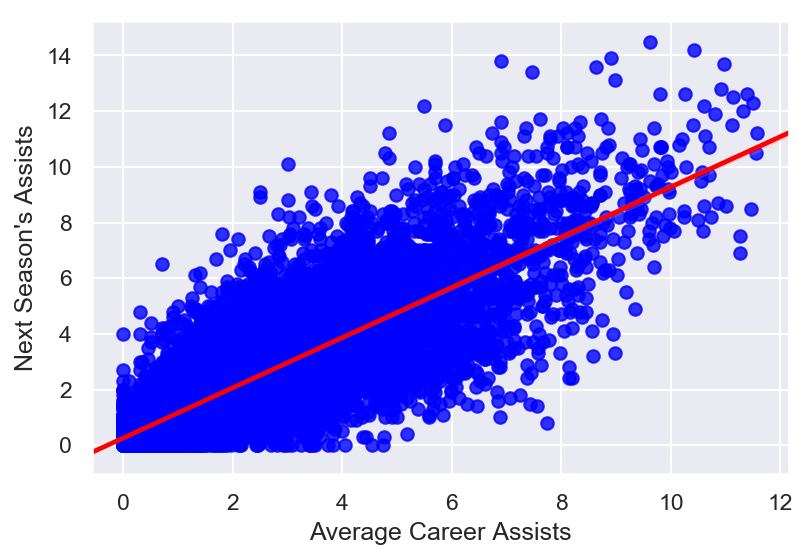

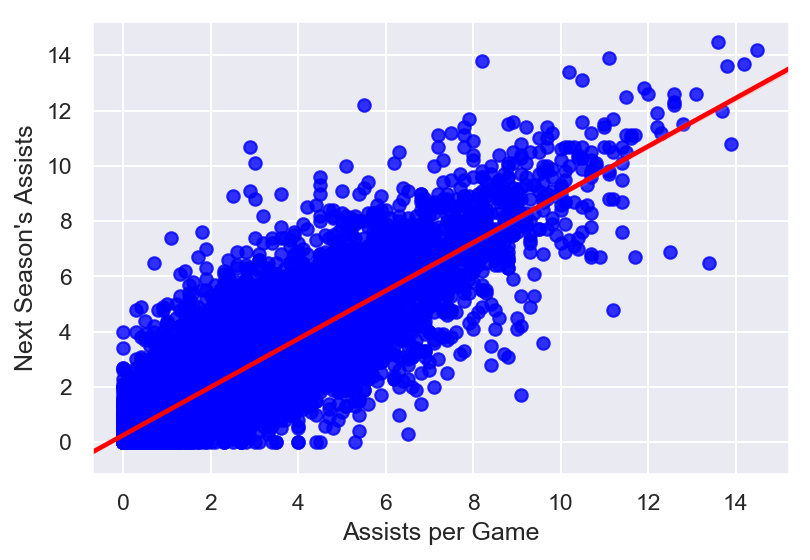

In [23]:
import seaborn as sns

sns.set(color_codes=True)

for i in range(4):
    plt.rcParams['figure.dpi'] = 150 # Setting this so it looks better in the app.
    ax = sns.regplot(x=names[i], y='Target', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    ax.set_xlabel(meanings[i])
    ax.set_ylabel("Next Season's Assists")
    plt.show()

### "Shap Decision Plots"

I tried to make some actual [shap decision plots](https://nbviewer.jupyter.org/github/slundberg/shap/blob/master/notebooks/plots/decision_plot.ipynb), but I couldn't quite get it to work. So instead I made my own. They look much less pretty, but they get across the point.

In [25]:
# First, I want to get my test predictions into my dataframe.

y_pred = model.predict(X_test_encoded)

test['pred'] = y_pred
test['mse'] = (test['Target'] - test['pred'])**2 # Easier to just do the MSE math directly like this.
test['diff'] = abs(test['AST'] - test['pred'])
test = test.sort_values(by='diff', ascending=False)
# I think the interesting thing to focus on is how different the prediction is from the actual result.

columns = test.columns
move = ['Player', 'Year', 'Tm', 'AST', 'Target', 'pred', 'diff', 'mse'] # Get the important columns to the front.
test = test[move + [c for c in columns if c not in move]]
test.head()

C:\Anaconda3\envs\unit2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda3\envs\unit2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda3\envs\unit2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
7597,J.J. Barea,2018.0,DAL,6.3,5.6,4.659137,1.640863,0.885222,NBA,1.0,...,60.892143,75.372143,14.224286,6.806429,20.767857,34.737143,204.477143,39.792857,38.780504,0.0
6919,Gordon Hayward,2018.0,BOS,0.0,3.4,1.295981,1.295981,4.426897,NBA,3.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
207,Al Horford,2018.0,BOS,4.7,4.2,3.489427,1.210573,0.504914,NBA,5.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,5.0
4803,Derrick Rose,2018.0,CLE,1.5,4.3,2.658635,1.158635,2.694078,NBA,1.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
5366,Draymond Green,2018.0,GSW,7.3,6.9,6.157524,1.142476,0.551271,NBA,4.0,...,71.032000,87.183333,19.292667,12.233333,29.250000,37.808667,259.846000,63.669333,58.806071,3.0


In [26]:
test.head(20)

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
7597,J.J. Barea,2018.0,DAL,6.3,5.6,4.659137,1.640863,0.885222,NBA,1.0,...,60.892143,75.372143,14.224286,6.806429,20.767857,34.737143,204.477143,39.792857,38.780504,0.0
6919,Gordon Hayward,2018.0,BOS,0.0,3.4,1.295981,1.295981,4.426897,NBA,3.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
207,Al Horford,2018.0,BOS,4.7,4.2,3.489427,1.210573,0.504914,NBA,5.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,5.0
4803,Derrick Rose,2018.0,CLE,1.5,4.3,2.658635,1.158635,2.694078,NBA,1.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
5366,Draymond Green,2018.0,GSW,7.3,6.9,6.157524,1.142476,0.551271,NBA,4.0,...,71.032000,87.183333,19.292667,12.233333,29.250000,37.808667,259.846000,63.669333,58.806071,3.0
16047,Spencer Dinwiddie,2018.0,BRK,6.6,4.6,5.487692,1.112308,0.787997,NBA,1.0,...,68.570000,84.990000,17.026111,8.796111,31.100556,44.442222,211.459444,44.926667,37.474447,0.0
13336,Nicolas Batum,2018.0,CHO,5.5,3.3,4.473933,1.026067,1.378119,NBA,2.0,...,109.176667,142.803333,19.480000,14.545833,32.824167,46.390000,284.152500,59.655000,54.242340,0.0
11762,Marc Gasol,2018.0,MEM,4.2,4.4,3.195699,1.004301,1.450340,NBA,5.0,...,54.952857,68.469286,13.418571,7.655714,23.582143,37.650000,188.910000,44.608571,44.795018,0.0
13586,PJ Dozier,2018.0,OKC,0.0,0.8,0.980278,0.980278,0.032500,NBA,1.0,...,93.617692,120.036923,20.800000,13.203077,38.917692,46.281538,306.173846,60.890769,58.300092,0.0
9534,John Wall,2018.0,WAS,9.6,8.7,8.629812,0.970188,0.004926,NBA,1.0,...,73.512667,96.262667,22.166667,8.672000,34.422667,46.284000,262.846000,68.821333,64.219207,5.0


In [27]:
# Next, I want to get the most important features.

permuter.feature_importances_

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.65643933e-02,  3.98116649e-02,  2.81556121e-02, -1.92966023e-03,
        2.70408426e-01, -3.16450599e-03, -2.15283447e-03, -2.32709972e-04,
        6.47346630e-05,  2.62994046e-03, -2.94717607e-07, -7.40584817e-04,
        5.86996327e-03, -3.31881629e-04, -7.89092371e-05,  1.95456798e-02,
        4.84378441e-03, -2.41052207e-04,  1.63843505e-03,  1.47447602e-02,
        6.12726188e-04,  3.87592886e-03,  8.75861497e-04,  9.17026627e-03,
        4.29281207e-04,  3.70948532e-02,  7.44538202e-01,  7.69307243e-01,
       -8.23359531e-03,  6.10576090e-02,  2.00491001e-01,  2.84540940e-02,
        3.32196347e-01,  5.57417958e-03, -2.41349134e-05,  1.82071311e-01,
        1.81924965e-01,  1.47284335e-01,  3.70224954e-02,  1.32147401e-01,
        1.75920717e-02,  1.05975328e-03, -8.47361916e-04, -1.24264408e-03,
        3.44206720e-02,  1.84213683e-02, -8.52194442e-05,  1.40564721e-03,
        2.75396171e-03,  

In [30]:
# More helpful to get them in a dataframe like this.

importances = pd.DataFrame(permuter.feature_importances_, index=X_test_encoded.columns)
importances = importances.reset_index() # This is the easiest way for me to create just two columns.
importances.columns = ['name', 'importance']
importances

,name,importance
0,Lge_NBA,0.000000
1,Lge_ABA,0.000000
2,Lge_BAA,0.000000
3,Year,0.000000
4,Pos,0.056564
...,...,...
98,TM_PF_adj,-0.001383
99,TM_PTS_adj,0.366116
100,TM_AST_adj,0.003933
101,TM_CAS_adj,0.004343


In [32]:
# 0.1 seems like a good cutoff.

imp_features = importances.loc[importances['importance'] > 0.1]
imp_features = imp_features.sort_values(by='importance', ascending=False)
imp_features

,name,importance
53,PTS_adj,0.942199
54,AST_adj,0.861159
31,CAS,0.769307
30,AST,0.744538
99,TM_PTS_adj,0.366116
36,3P_adj,0.332196
8,MP,0.270408
79,TM_FG_adj,0.257501
34,FGA_adj,0.200491
39,2P_adj,0.182071


In [45]:
# Now let's get the coefficients in there. Merge is the most efficient method.

coefs = pd.DataFrame(model.coef_, index=X_test_encoded.columns)
coefs = coefs.reset_index()
coefs.columns = ['name', 'coef']

imp_coefs = imp_features.merge(coefs, on='name', how='left')
        
imp_coefs

,name,importance,coef
0,PTS_adj,0.942199,-0.003214
1,AST_adj,0.861159,0.010213
2,CAS,0.769307,0.354137
3,AST,0.744538,0.325278
4,TM_PTS_adj,0.366116,0.007053
5,3P_adj,0.332196,0.014394
6,MP,0.270408,-0.043666
7,TM_FG_adj,0.257501,-0.020692
8,FGA_adj,0.200491,-0.001955
9,2P_adj,0.182071,0.004192


In [35]:
assert imp_features.shape[0] == imp_coefs.shape[0]

In [36]:
# Finally, I want the intercept in there.

model.intercept_

1.8731574118323828

In [47]:
intercept = pd.DataFrame([model.intercept_], index=['Start'])
intercept = intercept.reset_index()
intercept.columns = ['name', 'coef']
intercept['importance'] = np.nan
intercept = intercept[['name', 'importance', 'coef']]
intercept

,name,importance,coef
0,Start,NaN,1.873157


In [48]:
imp_coefs = pd.concat([intercept, imp_coefs])
imp_coefs

,name,importance,coef
0,Start,NaN,1.873157
0,PTS_adj,0.942199,-0.003214
1,AST_adj,0.861159,0.010213
2,CAS,0.769307,0.354137
3,AST,0.744538,0.325278
4,TM_PTS_adj,0.366116,0.007053
5,3P_adj,0.332196,0.014394
6,MP,0.270408,-0.043666
7,TM_FG_adj,0.257501,-0.020692
8,FGA_adj,0.200491,-0.001955


In [91]:
# Now I'm set up to show how a single row's prediction works.
# Let's take another look at the test dataframe.

test.head(30)

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
7597,J.J. Barea,2018.0,DAL,6.3,5.6,4.659137,1.640863,0.885222,NBA,1.0,...,60.892143,75.372143,14.224286,6.806429,20.767857,34.737143,204.477143,39.792857,38.780504,0.0
6919,Gordon Hayward,2018.0,BOS,0.0,3.4,1.295981,1.295981,4.426897,NBA,3.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
207,Al Horford,2018.0,BOS,4.7,4.2,3.489427,1.210573,0.504914,NBA,5.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,5.0
4803,Derrick Rose,2018.0,CLE,1.5,4.3,2.658635,1.158635,2.694078,NBA,1.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
5366,Draymond Green,2018.0,GSW,7.3,6.9,6.157524,1.142476,0.551271,NBA,4.0,...,71.032000,87.183333,19.292667,12.233333,29.250000,37.808667,259.846000,63.669333,58.806071,3.0
16047,Spencer Dinwiddie,2018.0,BRK,6.6,4.6,5.487692,1.112308,0.787997,NBA,1.0,...,68.570000,84.990000,17.026111,8.796111,31.100556,44.442222,211.459444,44.926667,37.474447,0.0
13336,Nicolas Batum,2018.0,CHO,5.5,3.3,4.473933,1.026067,1.378119,NBA,2.0,...,109.176667,142.803333,19.480000,14.545833,32.824167,46.390000,284.152500,59.655000,54.242340,0.0
11762,Marc Gasol,2018.0,MEM,4.2,4.4,3.195699,1.004301,1.450340,NBA,5.0,...,54.952857,68.469286,13.418571,7.655714,23.582143,37.650000,188.910000,44.608571,44.795018,0.0
13586,PJ Dozier,2018.0,OKC,0.0,0.8,0.980278,0.980278,0.032500,NBA,1.0,...,93.617692,120.036923,20.800000,13.203077,38.917692,46.281538,306.173846,60.890769,58.300092,0.0
9534,John Wall,2018.0,WAS,9.6,8.7,8.629812,0.970188,0.004926,NBA,1.0,...,73.512667,96.262667,22.166667,8.672000,34.422667,46.284000,262.846000,68.821333,64.219207,5.0


In [52]:
# Let's do John Wall first--a player my model significantly outperformed the baseline on.

row_t = X_test_encoded.loc[[9534]].T # I want it transmuted for the sake of the merge.
row_t

,9534
Lge_NBA,1.000000
Lge_ABA,0.000000
Lge_BAA,0.000000
Year,2018.000000
Pos,1.000000
...,...
TM_PF_adj,46.284000
TM_PTS_adj,262.846000
TM_AST_adj,68.821333
TM_CAS_adj,64.219207


In [53]:
row_t = row_t.reset_index()
row_t.columns = ['name', 'value']
row_t

,name,value
0,Lge_NBA,1.000000
1,Lge_ABA,0.000000
2,Lge_BAA,0.000000
3,Year,2018.000000
4,Pos,1.000000
...,...,...
98,TM_PF_adj,46.284000
99,TM_PTS_adj,262.846000
100,TM_AST_adj,68.821333
101,TM_CAS_adj,64.219207


In [64]:
# Let's merge them!

predict_row1 = imp_coefs.merge(row_t, on='name', how='left')
predict_row1

,name,importance,coef,value
0,Start,NaN,1.873157,NaN
1,PTS_adj,0.942199,-0.003214,667.360000
2,AST_adj,0.861159,0.010213,330.240000
3,CAS,0.769307,0.354137,9.150000
4,AST,0.744538,0.325278,9.600000
5,TM_PTS_adj,0.366116,0.007053,262.846000
6,3P_adj,0.332196,0.014394,51.600000
7,MP,0.270408,-0.043666,34.400000
8,TM_FG_adj,0.257501,-0.020692,97.454667
9,FGA_adj,0.200491,-0.001955,560.720000


In [65]:
# I can get the predictions by multiplying the value by the coef!

predict_row1['pred'] = predict_row1['coef'] * predict_row1['value']
predict_row1

,name,importance,coef,value,pred
0,Start,NaN,1.873157,NaN,NaN
1,PTS_adj,0.942199,-0.003214,667.360000,-2.145209
2,AST_adj,0.861159,0.010213,330.240000,3.372636
3,CAS,0.769307,0.354137,9.150000,3.240355
4,AST,0.744538,0.325278,9.600000,3.122673
5,TM_PTS_adj,0.366116,0.007053,262.846000,1.853879
6,3P_adj,0.332196,0.014394,51.600000,0.742713
7,MP,0.270408,-0.043666,34.400000,-1.502118
8,TM_FG_adj,0.257501,-0.020692,97.454667,-2.016484
9,FGA_adj,0.200491,-0.001955,560.720000,-1.096264


In [66]:
# I want to have the biggest changes first, so let's sort by that.
# But first, I'll set "Start" to have a really high abs_pred,
# so that I can guarantee it's at the top.

predict_row1['abs_pred'] = abs(predict_row1['pred'])
predict_row1.loc[0, 'abs_pred'] = 10000
predict_row1 = predict_row1.sort_values(by='abs_pred', ascending=False)
predict_row1.loc[0, 'pred'] = predict_row1.loc[0, 'coef']
# I want the intercept value with all the other predictions.
predict_row1

,name,importance,coef,value,pred,abs_pred
0,Start,NaN,1.873157,NaN,1.873157,10000.000000
2,AST_adj,0.861159,0.010213,330.240000,3.372636,3.372636
3,CAS,0.769307,0.354137,9.150000,3.240355,3.240355
4,AST,0.744538,0.325278,9.600000,3.122673,3.122673
1,PTS_adj,0.942199,-0.003214,667.360000,-2.145209,2.145209
8,TM_FG_adj,0.257501,-0.020692,97.454667,-2.016484,2.016484
5,TM_PTS_adj,0.366116,0.007053,262.846000,1.853879,1.853879
14,CAS_adj,0.105319,-0.004927,314.760000,-1.550894,1.550894
7,MP,0.270408,-0.043666,34.400000,-1.502118,1.502118
9,FGA_adj,0.200491,-0.001955,560.720000,-1.096264,1.096264


In [69]:
predict_row1 = predict_row1.reset_index(drop=True)
results = []
for i in range(len(predict_row1)):
    if i == 0:
        results.append(predict_row1.loc[i, 'pred'])
    else:
        result = results[i-1] + predict_row1.loc[i, 'pred'] # This is how each pred impacts the rest.
        results.append(result)
        
predict_row1['results'] = results
predict_row1

,name,importance,coef,value,pred,abs_pred,results
0,Start,NaN,1.873157,NaN,1.873157,10000.000000,1.873157
1,AST_adj,0.861159,0.010213,330.240000,3.372636,3.372636,5.245793
2,CAS,0.769307,0.354137,9.150000,3.240355,3.240355,8.486148
3,AST,0.744538,0.325278,9.600000,3.122673,3.122673,11.608820
4,PTS_adj,0.942199,-0.003214,667.360000,-2.145209,2.145209,9.463612
5,TM_FG_adj,0.257501,-0.020692,97.454667,-2.016484,2.016484,7.447128
6,TM_PTS_adj,0.366116,0.007053,262.846000,1.853879,1.853879,9.301007
7,CAS_adj,0.105319,-0.004927,314.760000,-1.550894,1.550894,7.750113
8,MP,0.270408,-0.043666,34.400000,-1.502118,1.502118,6.247994
9,FGA_adj,0.200491,-0.001955,560.720000,-1.096264,1.096264,5.151731


9.1 is fairly different from the actual prediction...but oh well.

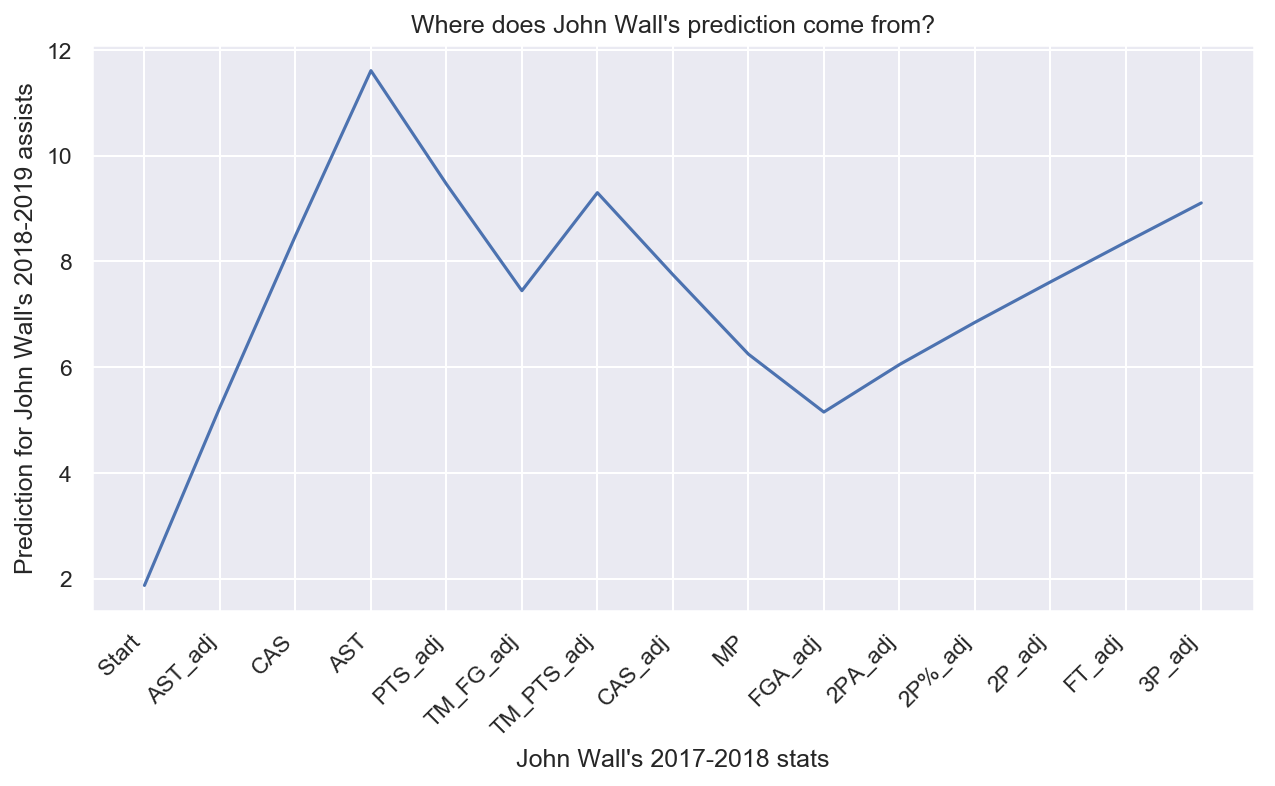

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
plt.rcParams['figure.dpi'] = 150

plt.plot(np.arange(0, len(predict_row1)), predict_row1['results'])
ax.set_xticks(np.arange(0, len(predict_row1)))
ax.set_xticklabels(predict_row1['name'], rotation=45, ha='right')
ax.set_xlabel("John Wall's 2017-2018 stats")
ax.set_ylabel("Prediction for John Wall's 2018-2019 assists")
ax.set_title("Where does John Wall's prediction come from?");

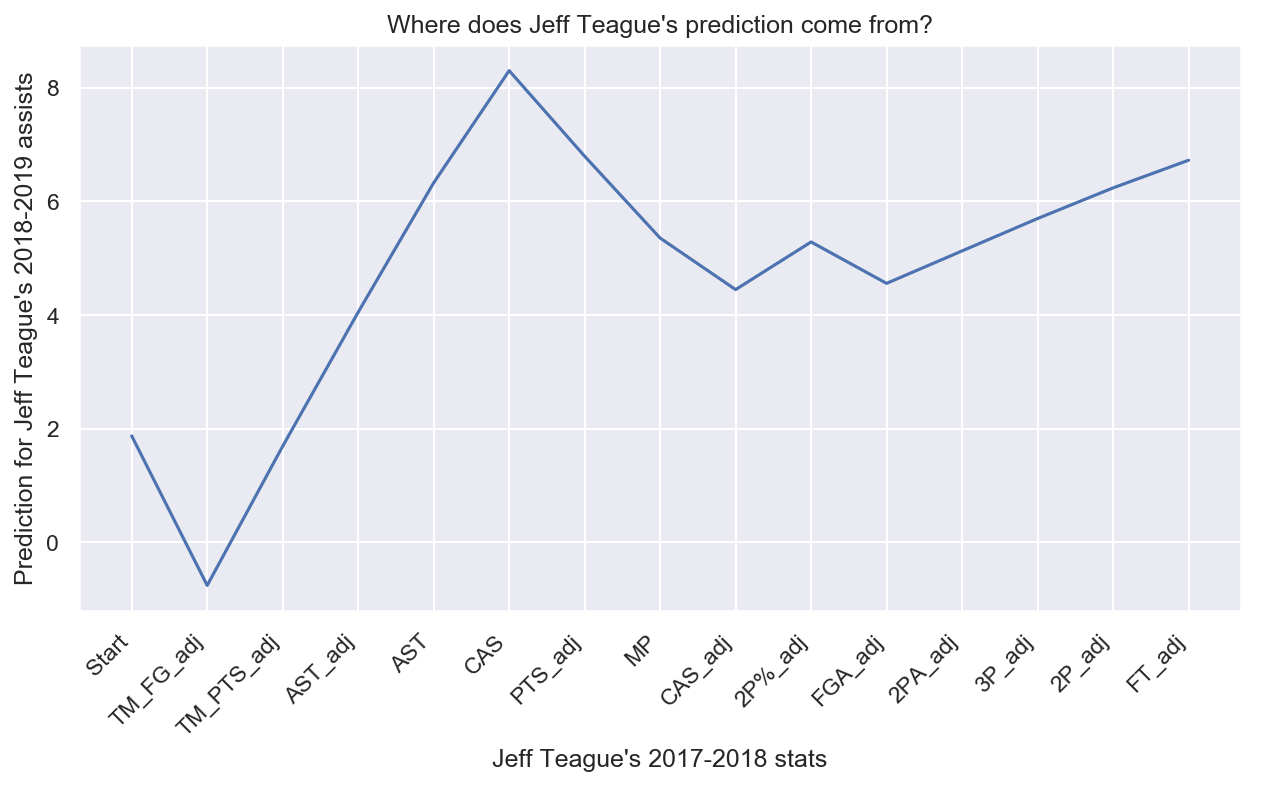

In [90]:
# Now that I got it working, let's set up a function to do it automatically.

def explain(row):
    row_t = X_test_encoded.loc[[row]].T
    row_t = row_t.reset_index()
    row_t.columns = ['name', 'value']
    
    predict_row = imp_coefs.merge(row_t, on='name', how='left')
    predict_row['pred'] = predict_row['coef'] * predict_row['value']
    predict_row['abs_pred'] = abs(predict_row['pred'])
    predict_row.loc[0, 'abs_pred'] = 10000
    predict_row = predict_row.sort_values(by='abs_pred', ascending=False)
    predict_row.loc[0, 'pred'] = predict_row.loc[0, 'coef']
    
    predict_row = predict_row.reset_index(drop=True)
    results = []
    for i in range(len(predict_row)):
        if i == 0:
            results.append(predict_row.loc[i, 'pred'])
        else:
            result = results[i-1] + predict_row.loc[i, 'pred']
            results.append(result)
    predict_row['results'] = results
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10,5)
    plt.rcParams['figure.dpi'] = 150

    plt.plot(np.arange(0, len(predict_row)), predict_row['results'])
    ax.set_xticks(np.arange(0, len(predict_row)))
    ax.set_xticklabels(predict_row['name'], rotation=45, ha='right')
    player_name = test.loc[row, 'Player']
    ax.set_xlabel(f"{player_name}'s 2017-2018 stats")
    ax.set_ylabel(f"Prediction for {player_name}'s 2018-2019 assists")
    ax.set_title(f"Where does {player_name}'s prediction come from?")
    return plt.show()

explain(8455) # This is one my model was wrong on.

In [87]:
test.tail(30)

,Player,Year,Tm,AST,Target,pred,diff,mse,Lge,Pos,...,TM_DRB_adj,TM_TRB_adj,TM_STL_adj,TM_BLK_adj,TM_TOV_adj,TM_PF_adj,TM_PTS_adj,TM_AST_adj,TM_CAS_adj,Sels
16616,Terry Rozier,2018.0,BOS,2.9,2.9,2.942720,0.042720,0.001825,NBA,1.0,...,81.115455,103.566364,20.738182,9.902727,36.218182,44.066364,323.647273,73.960000,61.300965,0.0
14802,Robert Covington,2018.0,PHI,2.0,1.3,1.958324,0.041676,0.433390,NBA,3.0,...,73.906667,95.956667,16.640556,12.073333,35.935000,43.799444,227.917222,44.559444,36.570538,0.0
4777,Derrick Favors,2018.0,UTA,1.3,1.2,1.259123,0.040877,0.003496,NBA,5.0,...,84.770000,107.950000,18.970769,11.906154,27.908462,44.989231,210.409231,53.608462,54.882762,0.0
17406,Tyler Cavanaugh,2018.0,ATL,0.7,0.1,0.738097,0.038097,0.407167,NBA,4.0,...,44.683846,57.088462,11.313077,6.192308,22.874615,31.876923,154.285385,37.631538,27.552753,0.0
9719,Jonas Jerebko,2018.0,UTA,0.6,1.3,0.637867,0.037867,0.438420,NBA,4.0,...,84.770000,107.950000,18.970769,11.906154,27.908462,44.989231,210.409231,53.608462,54.882762,0.0
17430,Tyler Zeller,2018.0,BRK,0.7,0.7,0.663070,0.036930,0.001364,NBA,5.0,...,68.570000,84.990000,17.026111,8.796111,31.100556,44.442222,211.459444,44.926667,37.474447,0.0
10764,Kyle Korver,2018.0,CLE,1.2,1.2,1.164519,0.035481,0.001259,NBA,2.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
8378,Jeff Green,2018.0,CLE,1.3,1.8,1.331080,0.031080,0.219886,NBA,4.0,...,106.968824,135.421176,24.157647,10.841176,46.918235,53.872941,411.128235,83.418824,90.010933,0.0
12898,Mike Scott,2018.0,WAS,1.1,0.8,1.069573,0.030427,0.072670,NBA,4.0,...,73.512667,96.262667,22.166667,8.672000,34.422667,46.284000,262.846000,68.821333,64.219207,0.0
612,Andrew Bogut,2018.0,LAL,0.6,1.0,0.570363,0.029637,0.184588,NBA,5.0,...,77.592667,101.189333,17.511333,11.958000,35.534667,47.350667,274.166000,53.672667,50.151133,0.0


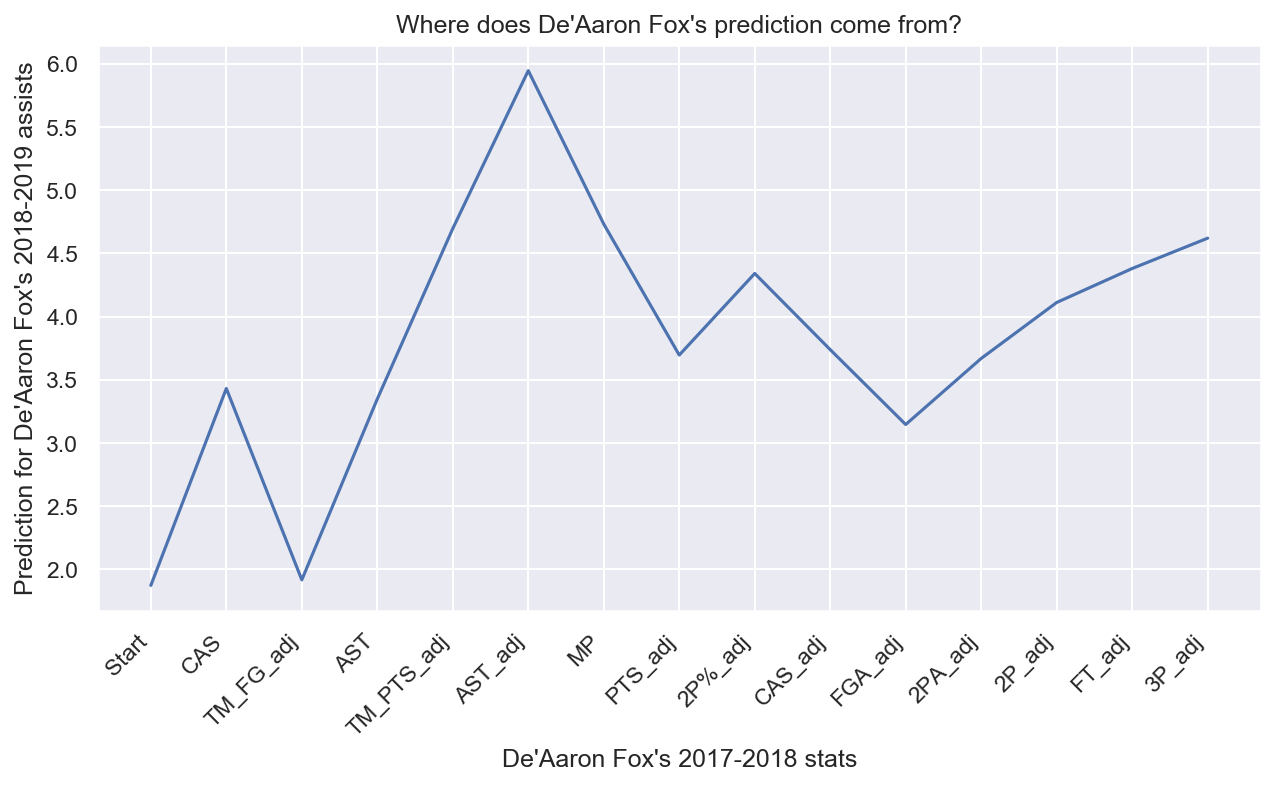

In [75]:
explain(4463) # The baseline and the model were both very wrong about him.

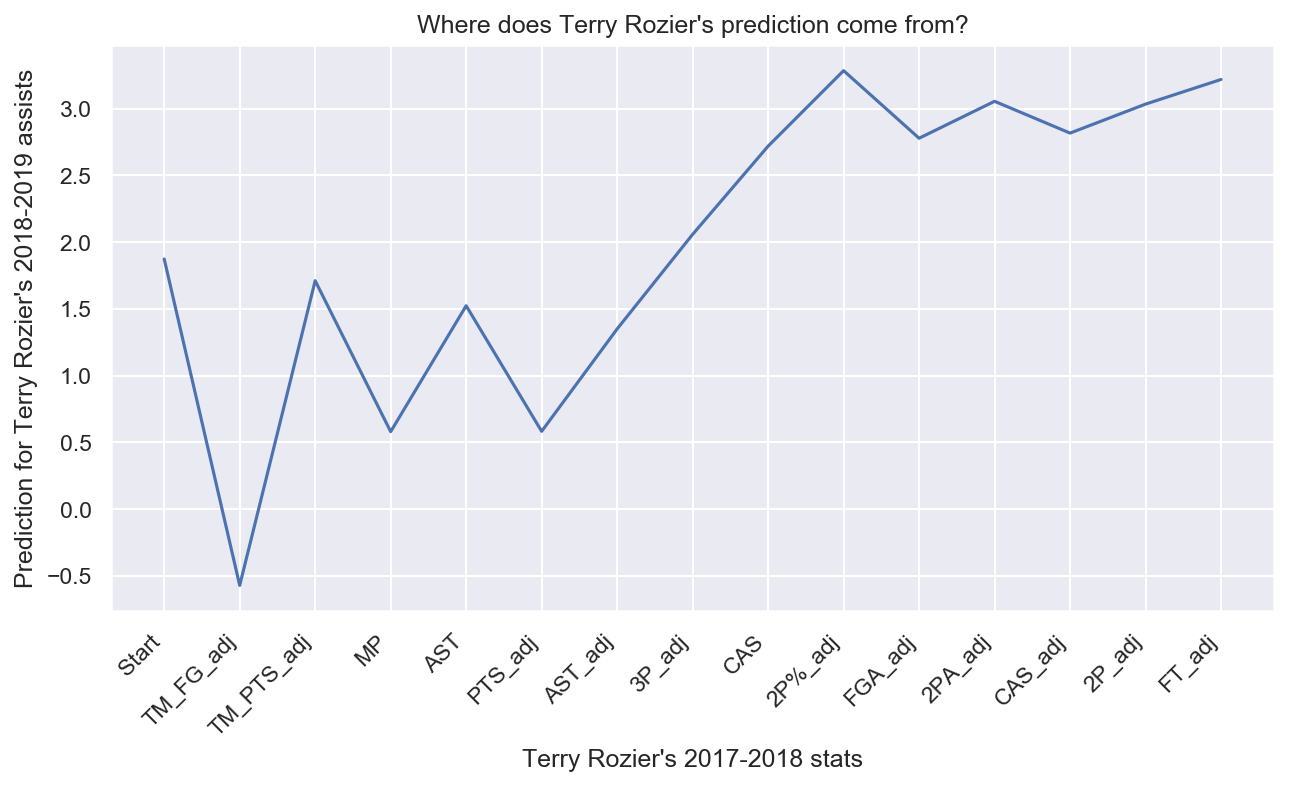

In [88]:
explain(16616) # On the other hand, we were both very right about him.